In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os,gc

from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from pydotplus import graph_from_dot_data
from IPython.display import Image

In [2]:
# ログのライブラリ
import logging
from logging import getLogger, StreamHandler, Formatter

# --------------------------------
# 1.loggerの設定
# --------------------------------
# loggerオブジェクトの宣言
logger = getLogger("logging")

# loggerのログレベル設定(ハンドラに渡すエラーメッセージのレベル)
logger.setLevel(logging.DEBUG)

# --------------------------------
# 2.handlerの設定
# --------------------------------
# handlerの生成
stream_handler = StreamHandler()

# handlerのログレベル設定(ハンドラが出力するエラーメッセージのレベル)
stream_handler.setLevel(logging.DEBUG)

# ログ出力フォーマット設定
handler_format = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(handler_format)

# --------------------------------
# 3.loggerにhandlerをセット
# --------------------------------
logger.addHandler(stream_handler)

# --------------------------------
# ログ出力テスト
# --------------------------------
logger.info("Hello World!")



2019-07-14 13:06:52,094 - logging - INFO - Hello World!


# settings

In [3]:
d_home = Path('../')
d_output = d_home/'output'

# udf

In [4]:
def visualizeTreeStructure(decision_tree,feature_names=None):
    '''return text data'''
    
    # retrieve decision tree structure information
    txt = ''
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    
    # define each node is leaf or not
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    txt += "The binary tree structure has {} nodes and has the following tree structure:".format(n_nodes) 
    for i in range(n_nodes):
        if is_leaves[i]:
            txt += "\n{}node={} leaf node.".format(node_depth[i] * "\t", i)
        else:
            if feature_names is None:
                txt+= "\n{}node={} test node: go to node {} if X[{:.0f}] <= {} else to node {}.".format(node_depth[i] * "\t",
                         i,
                         children_left[i],
                         feature[i],
                         threshold[i],
                         children_right[i],
                         )
            else:
                txt+= "\n{}node={} test node: go to node {} if {} <= {} else to node {}.".format(node_depth[i] * "\t",
                         i,
                         children_left[i],
                         feature_names[feature[i]],
                         threshold[i],
                         children_right[i],
                         )
    return txt

def extractDecisionInfo(decision_tree,X_train,feature_names=None,only_leaves=False):
    '''return dataframe with node info
    '''
    
    # extract info from decision_tree
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold
    impurity = decision_tree.tree_.impurity
    value = decision_tree.tree_.value
    n_node_samples = decision_tree.tree_.n_node_samples
    
    # cast X_train as dataframe
    df = pd.DataFrame(X_train)
    if feature_names is not None:
        df.columns = feature_names
    
    # indexes with unique nodes
    idx_list = df.assign(
        leaf_id = lambda df: decision_tree.apply(df)
    )[['leaf_id']].drop_duplicates().index

    # test data for unique nodes
    X_test = df.loc[idx_list,].to_numpy()
    # decision path only for leaves
    dp = decision_tree.decision_path(X_test)
    # final leaves for each data
    leave_id = decision_tree.apply(X_test)
    # values for each data
    leave_predict = decision_tree.predict(X_test)
    # dictionary for leave_id and leave_predict
    dict_leaves = {k:v for k,v in zip(leave_id,leave_predict)}
    
    # create decision path information for all nodes
    dp_idxlist = [[ini, fin] for ini,fin in zip(dp.indptr[:-1],dp.indptr[1:])]
    dict_decisionpath = {}
    for idxs in dp_idxlist:
        dpindices = dp.indices[idxs[0]:idxs[1]]
        for i,node in enumerate(dpindices):
            if node not in dict_decisionpath.keys():
                dict_decisionpath[node] = dpindices[:i+1]
    
    # initialize number of columns and output dataframe
    n_cols = df.shape[-1]
    df_thr_all = pd.DataFrame()

    # predict for samples
    
    for node, node_index in dict_decisionpath.items():
        l_thresh_max = np.ones(n_cols) * np.nan
        l_thresh_min = np.ones(n_cols) * np.nan
        
        # decision path info for each node
        for i,node_id in enumerate(node_index):
            if node == node_id:
                continue

            if children_left[node_id] == node_index[i+1]: #(X_test[sample_id, feature[node_id]] <= threshold[node_id]):
                l_thresh_max[feature[node_id]] = threshold[node_id]
            else:
                l_thresh_min[feature[node_id]] = threshold[node_id]

        # append info to df_thr_all
        df_thr_all = df_thr_all.append(
            [[(thr_min,thr_max) for thr_max,thr_min in zip(l_thresh_max,l_thresh_min)]
             + [
                 node,
                 np.nan if node not in dict_leaves.keys() else dict_leaves[node],
                 value[node],
                 impurity[node],
                 n_node_samples[node]
               ]
            ]
        )

    # rename columns and set index
    if feature_names is not None:
        df_thr_all.columns = feature_names + ['node','predicted_value','value','impurity','n_node_samples']
    else:
        df_thr_all.columns = ['X_{}'.format(i) for i in range(n_cols)] + ['node','predicted_value','value','impurity','n_node_samples']
    df_thr_all = df_thr_all.set_index('node')
    
    if only_leaves:
        df_thr_all = df_thr_all[~df_thr_all['predicted_value'].isnull()]
    
    return df_thr_all.sort_index()

# load iris dataset

In [5]:
iris = load_iris()
dtc = DecisionTreeClassifier(max_depth=5,min_samples_leaf=10)
dtc.fit(iris['data'],iris['target'])
# df_iris.head()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

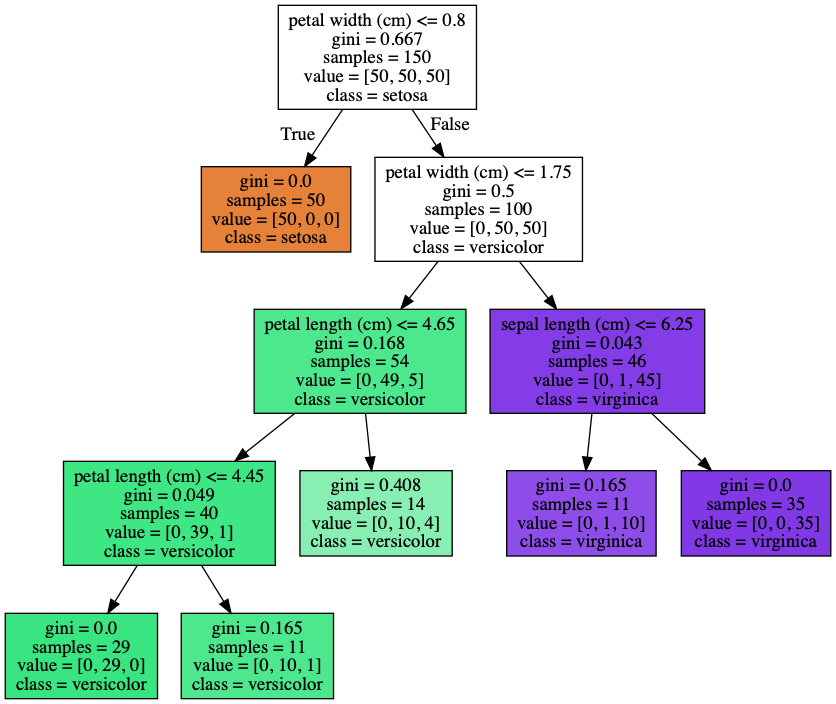

In [6]:
output = d_output/'output_with_graphviz.png'

dotdata = export_graphviz(
    decision_tree=dtc,
    class_names=iris['target_names'],
    feature_names=iris['feature_names'],
    filled=True
)
graph = graph_from_dot_data(dotdata,)
graph.write_png(path=output.as_posix())
Image(graph.create_png())

In [7]:
print(visualizeTreeStructure(dtc,feature_names=iris['feature_names']))

The binary tree structure has 11 nodes and has the following tree structure:
node=0 test node: go to node 1 if petal width (cm) <= 0.800000011920929 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if petal width (cm) <= 1.75 else to node 8.
		node=3 test node: go to node 4 if petal length (cm) <= 4.6499998569488525 else to node 7.
			node=4 test node: go to node 5 if petal length (cm) <= 4.450000047683716 else to node 6.
				node=5 leaf node.
				node=6 leaf node.
			node=7 leaf node.
		node=8 test node: go to node 9 if sepal length (cm) <= 6.25 else to node 10.
			node=9 leaf node.
			node=10 leaf node.


In [8]:
print(visualizeTreeStructure(dtc))

The binary tree structure has 11 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[3] <= 0.800000011920929 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[3] <= 1.75 else to node 8.
		node=3 test node: go to node 4 if X[2] <= 4.6499998569488525 else to node 7.
			node=4 test node: go to node 5 if X[2] <= 4.450000047683716 else to node 6.
				node=5 leaf node.
				node=6 leaf node.
			node=7 leaf node.
		node=8 test node: go to node 9 if X[0] <= 6.25 else to node 10.
			node=9 leaf node.
			node=10 leaf node.


# create decision path df

In [11]:
extractDecisionInfo(dtc,iris['data'],iris['feature_names'])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predicted_value,value,impurity,n_node_samples
node,,,,,,,,
0,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",NaN,"[[50.0, 50.0, 50.0]]",0.666667,150
1,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, 0.800000011920929)",0.0,"[[50.0, 0.0, 0.0]]",0.000000,50
2,"(nan, nan)","(nan, nan)","(nan, nan)","(0.800000011920929, nan)",NaN,"[[0.0, 50.0, 50.0]]",0.500000,100
3,"(nan, nan)","(nan, nan)","(nan, nan)","(0.800000011920929, 1.75)",NaN,"[[0.0, 49.0, 5.0]]",0.168038,54
4,"(nan, nan)","(nan, nan)","(nan, 4.6499998569488525)","(0.800000011920929, 1.75)",NaN,"[[0.0, 39.0, 1.0]]",0.048750,40
5,"(nan, nan)","(nan, nan)","(nan, 4.450000047683716)","(0.800000011920929, 1.75)",1.0,"[[0.0, 29.0, 0.0]]",0.000000,29
6,"(nan, nan)","(nan, nan)","(4.450000047683716, 4.6499998569488525)","(0.800000011920929, 1.75)",1.0,"[[0.0, 10.0, 1.0]]",0.165289,11
7,"(nan, nan)","(nan, nan)","(4.6499998569488525, nan)","(0.800000011920929, 1.75)",1.0,"[[0.0, 10.0, 4.0]]",0.408163,14
8,"(nan, nan)","(nan, nan)","(nan, nan)","(1.75, nan)",NaN,"[[0.0, 1.0, 45.0]]",0.042533,46


In [13]:
extractDecisionInfo(dtc,iris['data'],only_leaves=True)

,X_0,X_1,X_2,X_3,predicted_value,value,impurity,n_node_samples
node,,,,,,,,
1,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, 0.800000011920929)",0.0,"[[50.0, 0.0, 0.0]]",0.000000,50
5,"(nan, nan)","(nan, nan)","(nan, 4.450000047683716)","(0.800000011920929, 1.75)",1.0,"[[0.0, 29.0, 0.0]]",0.000000,29
6,"(nan, nan)","(nan, nan)","(4.450000047683716, 4.6499998569488525)","(0.800000011920929, 1.75)",1.0,"[[0.0, 10.0, 1.0]]",0.165289,11
7,"(nan, nan)","(nan, nan)","(4.6499998569488525, nan)","(0.800000011920929, 1.75)",1.0,"[[0.0, 10.0, 4.0]]",0.408163,14
9,"(nan, 6.25)","(nan, nan)","(nan, nan)","(1.75, nan)",2.0,"[[0.0, 1.0, 10.0]]",0.165289,11
10,"(6.25, nan)","(nan, nan)","(nan, nan)","(1.75, nan)",2.0,"[[0.0, 0.0, 35.0]]",0.000000,35
